In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
color = sns.color_palette()
%matplotlib inline

from utils import *
import re
import operator
from wordcloud import WordCloud

pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import *
from tensorflow.keras import backend as K
from transformers import *

import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

from transformers import logging
logging.set_verbosity_error()

import tensorflow as tf
from tensorflow.distribute import MirroredStrategy
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *

import datetime

import warnings
warnings.filterwarnings('ignore')

## Loading and Reading the dataset

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
print("Training data shape: ",train.shape)
print("Testing data shape: ",test.shape)

Training data shape:  (159571, 8)
Testing data shape:  (153164, 2)


In [ ]:
# Distribution of train dataset 
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Checking the Null values

In [ ]:
# Train dataset 
print("comment text  =", train['comment_text'].isnull().sum())
print("toxic comment =", train['toxic'].isnull().sum())
print("sever toxic   =", train['severe_toxic'].isnull().sum())
print("obscene       =", train['obscene'].isnull().sum())
print("threat        =", train['threat'].isnull().sum())
print("insult        =", train['insult'].isnull().sum())
print("identity      =", train['identity_hate'].isnull().sum())

comment text  = 0
toxic comment = 0
sever toxic   = 0
obscene       = 0
threat        = 0
insult        = 0
identity      = 0


### Data visualzation

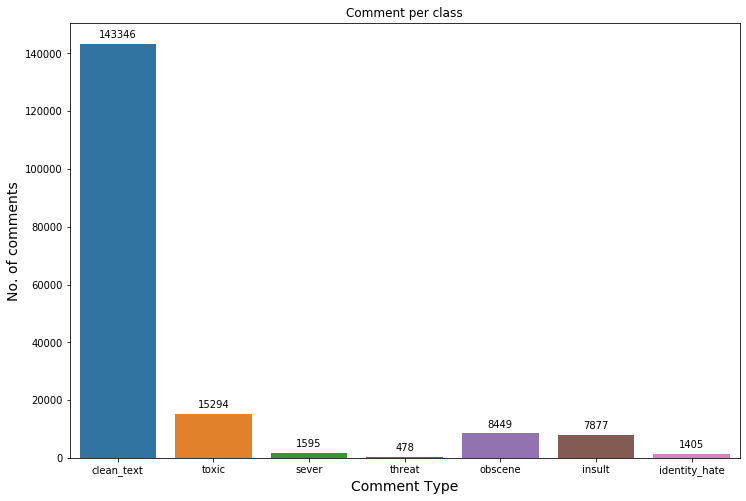

In [ ]:
clean_text = len(train[(train["toxic"]==0) & (train["severe_toxic"]==0) & (train["obscene"]==0) & 
                  (train["threat"]==0) &(train["insult"]==0) & (train["identity_hate"]==0)]) 
toxic = len(train[train["toxic"]==1])
sever =  len(train[train["severe_toxic"]==1])
threat = len(train[train["threat"]==1]) 
obscene = len(train[train["obscene"]==1])
insult = len(train[train["insult"]==1])
identity_hate = len(train[train["identity_hate"]==1])

labels = ["clean_text", "toxic", "sever", "threat", "obscene", "insult", "identity_hate"]
frequencies = [clean_text, toxic, sever, threat, obscene, insult, identity_hate]
freq_df = pd.DataFrame(list(zip(labels, frequencies)), columns =['label', 'frequencies'])

plt.figure(figsize=(12, 8))
fplot = sns.barplot(x="label",y="frequencies",data=freq_df)
for p in fplot.patches:
    fplot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title("Comment per class")
plt.xlabel("Comment Type", size=14)
plt.ylabel("No. of comments", size=14)
plt.show()

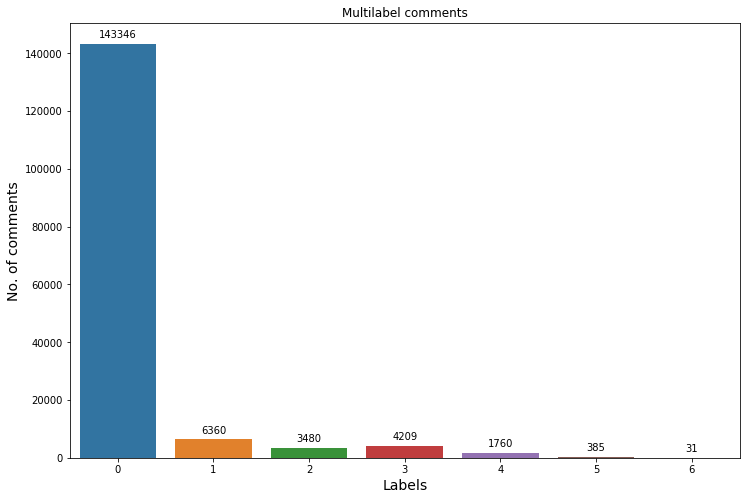

In [ ]:
cls = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
count_dict = train[cls].sum(axis=1).value_counts()
labels = count_dict.keys()
values = count_dict.values

count_df = pd.DataFrame(list(zip(labels, values)), columns =['labels', 'values'])

plt.figure(figsize=(12, 8))
countplot = sns.barplot(x="labels", y="values", data=count_df)
for p in countplot.patches:
    countplot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title("Multilabel comments")
plt.xlabel("Labels", size=14)
plt.ylabel("No. of comments", size=14)
plt.show()

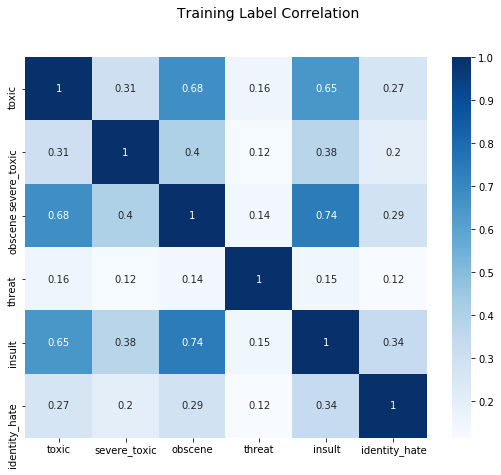

In [ ]:
fig = plt.figure(figsize = (9,7))
sns.heatmap(train.corr(), annot=True, cmap="Blues")
plt.suptitle('Training Label Correlation', size = 14)
plt.show()

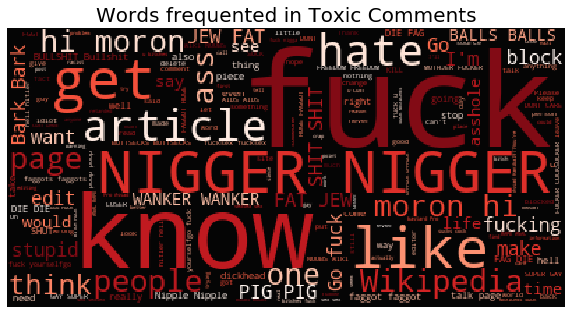

In [ ]:
stop_words = set(stopwords.words('english'))
subset = train[train.toxic==1]
text = subset.comment_text.values
wc = WordCloud(background_color="black",max_words=4000,stopwords=stop_words)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap='Reds', random_state=244), alpha=0.98)
plt.show()

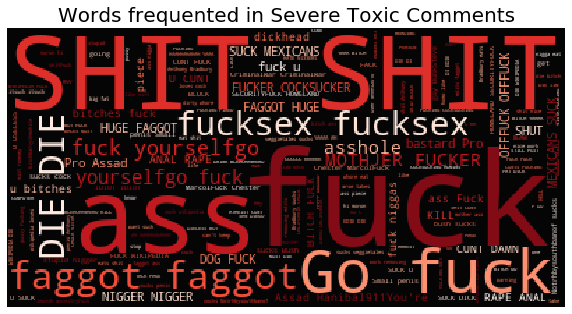

In [ ]:
subset = train[train.severe_toxic==1]
text = subset.comment_text.values
wc = WordCloud(background_color="black", max_words=4000, stopwords=stop_words)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap='Reds', random_state=244), alpha=0.98)
plt.show()

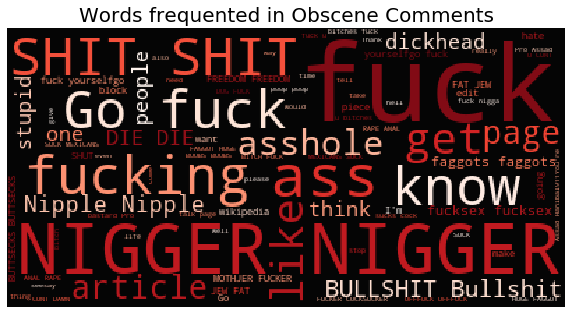

In [ ]:
subset = train[train.obscene==1]
text = subset.comment_text.values
wc = WordCloud(background_color="black", max_words=4000, stopwords=stop_words)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Words frequented in Obscene Comments", fontsize=20)
plt.imshow(wc.recolor(colormap='Reds', random_state=244), alpha=0.98)
plt.show()

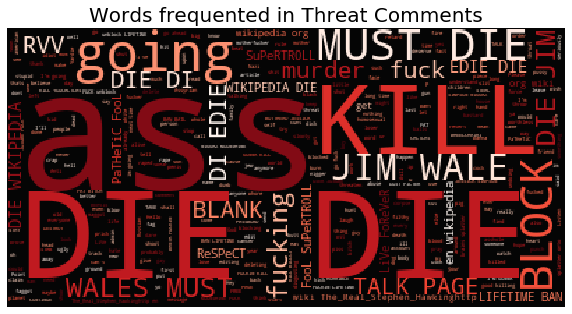

In [ ]:
subset = train[train.threat==1]
text = subset.comment_text.values
wc = WordCloud(background_color="black", max_words=4000, stopwords=stop_words)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Words frequented in Threat Comments", fontsize=20)
plt.imshow(wc.recolor(colormap='Reds', random_state=244), alpha=0.98)
plt.show()

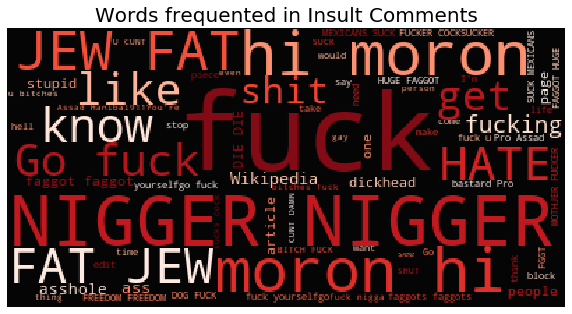

In [ ]:
subset = train[train.insult==1]
text = subset.comment_text.values
wc = WordCloud(background_color="black", max_words=4000, stopwords=stop_words)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Words frequented in Insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap='Reds', random_state=244), alpha=0.98)
plt.show()

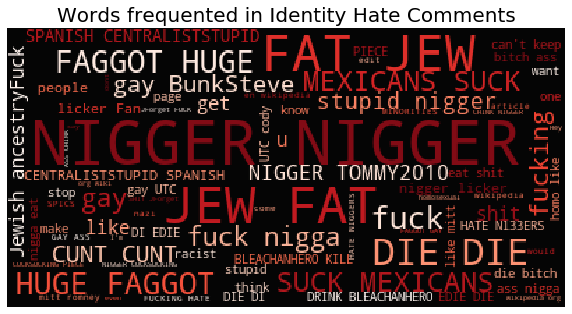

In [ ]:
subset = train[train.identity_hate==1]
text = subset.comment_text.values
wc = WordCloud(background_color="black", max_words=4000, stopwords=stop_words)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Words frequented in Identity Hate Comments", fontsize=20)
plt.imshow(wc.recolor(colormap='Reds', random_state=244), alpha=0.98)
plt.show()

## Data Cleaning

In [ ]:
contractions_dict = {"ain't": "is not",
                    "aren't": "are not",
                    "can't": "cannot", 
                    "can't've": "cannot have", 
                    "'cause": "because", 
                    "could've": "could have", 
                    "couldn't": "could not", 
                    "couldn't've": "could not have",
                    "didn't": "did not", 
                    "doesn't": "does not", 
                    "don't": "do not", 
                    "hadn't": "had not",  
                    "hadn't've": "had not have", 
                    "hasn't": "has not", 
                    "haven't": "have not", 
                    "he'd": "he would", 
                    "he'd've": "he would have", 
                    "he'll": "he will", 
                    "he'll've": "he will have", 
                    "he's": "he is", 
                    "how'd": "how did", 
                    "how'd'y": "how do you", 
                    "how'll": "how will", 
                    "how's": "how is", 
                    "I'd": "I would", 
                    "I'd've": "I would have", 
                    "I'll": "I will", 
                    "I'll've": "I will have",
                    "I'm": "I am", 
                    "I've": "I have", 
                    "i'd": "i would", 
                    "i'd've": "i would have", 
                    "i'll": "i will", 
                    "i'll've": "i will have",
                    "i'm": "i am", 
                    "i've": "i have", 
                    "isn't": "is not", 
                    "it'd": "it would", 
                    "it'd've": "it would have", 
                    "it'll": "it will", 
                    "it'll've": "it will have",
                    "it's": "it is", 
                    "let's": "let us", 
                    "ma'am": "madam", 
                    "mayn't": "may not", 
                    "might've": "might have",
                    "mightn't": "might not",
                    "mightn't've": "might not have", 
                    "must've": "must have", 
                    "mustn't": "must not", 
                    "mustn't've": "must not have", 
                    "needn't": "need not", 
                    "needn't've": "need not have",
                    "o'clock": "of the clock", 
                    "oughtn't": "ought not", 
                    "oughtn't've": "ought not have", 
                    "shan't": "shall not",
                    "sha'n't": "shall not", 
                    "shan't've": "shall not have", 
                    "she'd": "she would", 
                    "she'd've": "she would have", 
                    "she'll": "she will", 
                    "she'll've": "she will have", 
                    "she's": "she is", 
                    "should've": "should have", 
                    "shouldn't": "should not", 
                    "shouldn't've": "should not have", 
                    "so've": "so have",
                    "so's": "so as", 
                    "this's": "this is",
                    "that'd": "that would", 
                    "that'd've": "that would have",
                    "that's": "that is", 
                    "there'd": "there would", 
                    "there'd've": "there would have",
                    "there's": "there is", 
                    "here's": "here is",
                    "they'd": "they would", 
                    "they'd've": "they would have", 
                    "they'll": "they will", 
                    "they'll've": "they will have", 
                    "they're": "they are", 
                    "they've": "they have",
                    "to've": "to have", 
                    "wasn't": "was not", 
                    "we'd": "we would", 
                    "we'd've": "we would have", 
                    "we'll": "we will", 
                    "we'll've": "we will have", 
                    "we're": "we are", 
                    "we've": "we have", 
                    "weren't": "were not",
                    "what'll": "what will", 
                    "what'll've": "what will have", 
                    "what're": "what are", 
                    "what's": "what is", 
                    "what've": "what have", 
                    "when's": "when is", 
                    "when've": "when have", 
                    "where'd": "where did", 
                    "where's": "where is", 
                    "where've": "where have", 
                    "who'll": "who will", 
                    "who'll've": "who will have", 
                    "who's": "who is", 
                    "who've": "who have", 
                    "why's": "why is", 
                    "why've": "why have", 
                    "will've": "will have", 
                    "won't": "will not",
                    "won't've": "will not have", 
                    "would've": "would have", 
                    "wouldn't": "would not", 
                    "wouldn't've": "would not have", 
                    "y'all": "you all", 
                    "y'all'd": "you all would",
                    "y'all'd've": "you all would have",
                    "y'all're": "you all are",
                    "y'all've": "you all have",
                    "you'd": "you would", 
                    "you'd've": "you would have", 
                    "you'll": "you will", 
                    "you'll've": "you will have", 
                    "you're": "you are", 
                    "you've": "you have" }

In [ ]:
def expand_contractions(s, contractions_dict=contractions_dict):
    for key in contractions_dict:
        value = contractions_dict[key]
        s = s.replace(key, value)   
    return s

In [ ]:
def text_cleaner(s):
        s = str(s)
        s = s.lower()
        s = expand_contractions(s)
        s = re.sub("\n"," ",s)
        s = re.sub("\[.*\]"," ",s)
        s = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}"," ",s)
        s = re.sub(r"\?"," ",s)
        s = re.sub(r'[^\w\s]','',s)
        s = re.sub("\d+", "", s)
        s = re.sub(r'(\w)\1{2,}', r'\1\1', s) 
        s = re.sub(r'(\W)\1+', r'\1', s) 
        
        words = word_tokenize(s)
        lemmatizer = WordNetLemmatizer()
        words_lemma = []
        for word, tag in pos_tag(words):
            if tag.startswith("NN"):
                words_lemma.append(lemmatizer.lemmatize(word, pos='n'))
            elif tag.startswith('VB'):
                words_lemma.append(lemmatizer.lemmatize(word, pos='v'))
            elif tag.startswith('JJ'):
                words_lemma.append(lemmatizer.lemmatize(word, pos='a'))
            elif tag.startswith('R'):
                words_lemma.append(lemmatizer.lemmatize(word, pos='r'))    
            else:
                words_lemma.append(word)

        return (" ".join(words_lemma))

In [ ]:
print('Processing text dataset ...')

train["comment_text"] = train["comment_text"].fillna(" ")
test["comment_text"] = test["comment_text"].fillna(" ")
train['clean_comment_text'] = train['comment_text'].map(lambda x: text_cleaner(x))
test['clean_comment_text'] = test['comment_text'].map(lambda x: text_cleaner(x))

print('Train shape: ', train.shape)
print('Test shape: ', test.shape)

Processing text dataset ...
Train shape:  (159571, 9)
Test shape:  (153164, 3)


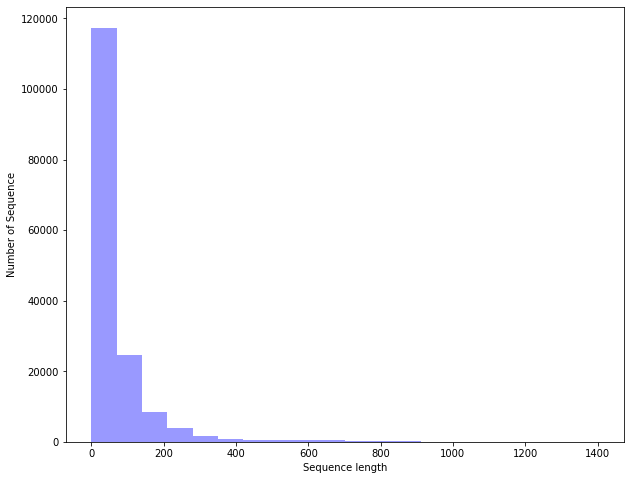

In [ ]:
seq_len_train = train['clean_comment_text'].apply(lambda s: len(str(s).split()))
seq_len_train_df = pd.DataFrame(list(seq_len_train), columns =['word_count'])

plt.figure(figsize=(10,8))
sns.distplot(seq_len_train_df['word_count'], kde=False, color='blue', bins=20)
plt.xlabel('Sequence length')
plt.ylabel('Number of Sequence')
plt.show()

### Train Test split

In [ ]:
CLASSES = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_lim = int(len(train) * 0.70)
test_lim = int(len(train) * 0.15)
y = train[CLASSES].values

X_train = train[:train_lim]
y_train = y[:train_lim]
X_val = train[train_lim:train_lim+test_lim]
y_val = y[train_lim:train_lim+test_lim]
X_test = train[train_lim+test_lim:]
y_test = y[train_lim+test_lim:]

### Configuration parameters

In [ ]:
EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
N_CLASS = len(CLASSES)
ES_PATIENCE = 3
MAX_SEQUENCE_LENGTH = 150
STEP_SIZE_TRAIN = len(train) // BATCH_SIZE

## Preprocessing and Tokenizing using Glove Vectors

In [ ]:
MAX_SEQUENCE_LENGTH = 150
MAX_NB_WORDS = 100000
EMBEDDING_DIM = 300
TRUNC_TYPE='post'
PADDING_TYPE='post'

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train['clean_comment_text'])

X_train_sequences = tokenizer.texts_to_sequences(X_train['clean_comment_text'])
X_train_padded_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                                       padding=PADDING_TYPE, truncating=TRUNC_TYPE)

X_val_sequences = tokenizer.texts_to_sequences(X_val['clean_comment_text'])
X_val_padded_sequences = pad_sequences(X_val_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                                       padding=PADDING_TYPE, truncating=TRUNC_TYPE)

X_test_sequences = tokenizer.texts_to_sequences(X_test['clean_comment_text'])
X_test_padded_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                                      padding=PADDING_TYPE, truncating=TRUNC_TYPE)

In [ ]:
embedding_index = {}
with open('glove.840B.300d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = ' '.join(values[:-300])
        coefs = np.asarray(values[-300:], dtype='float32')
        embedding_index[word] = coefs.reshape(-1)
        coef = embedding_index[word]
print('Total word vectors: %s' % len(embedding_index))

Total word vectors: 2195895


In [ ]:
word_index = tokenizer.word_index
vocab_size = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((vocab_size+1, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
print("Embedding matrix's shape: ", embedding_matrix.shape)

Embedding matrix's shape:  (100001, 300)


## Define the Bidirectional LSTM Model

In [ ]:
K.clear_session()
model = Sequential()
model.add(Embedding(vocab_size+1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, 
                    weights=[embedding_matrix], trainable=False, input_shape=(MAX_SEQUENCE_LENGTH,)))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(N_CLASS, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=LEARNING_RATE), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 300)          30000300  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dense (Dense)                (None, 32)                8224      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 30,448,146
Trainable params: 447,782
Non-trainable params: 30,000,364
______________________________________

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=ES_PATIENCE, mode='auto', verbose=1)
checkpoint = ModelCheckpoint("BiLSTM_GLOVE_840B_300D.h5", monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(X_train_padded_sequences, y_train, 
                    validation_data=(X_val_padded_sequences, y_val), verbose=1, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                    callbacks=[early_stop, checkpoint])

Epoch 1/10
1746/1746 [==============================] - ETA: 0s - loss: 0.1279 - accuracy: 0.8225
Epoch 00001: val_loss improved from inf to 0.06184, saving model to BiLSTM_GLOVE_840B_300D.h5
1746/1746 [==============================] - 116s 66ms/step - loss: 0.1279 - accuracy: 0.8225 - val_loss: 0.0618 - val_accuracy: 0.9924
Epoch 2/10
1746/1746 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9698
Epoch 00002: val_loss improved from 0.06184 to 0.05309, saving model to BiLSTM_GLOVE_840B_300D.h5
1746/1746 [==============================] - 115s 66ms/step - loss: 0.0610 - accuracy: 0.9698 - val_loss: 0.0531 - val_accuracy: 0.9937
Epoch 3/10
1746/1746 [==============================] - ETA: 0s - loss: 0.0561 - accuracy: 0.9845
Epoch 00003: val_loss improved from 0.05309 to 0.05305, saving model to BiLSTM_GLOVE_840B_300D.h5
1746/1746 [==============================] - 115s 66ms/step - loss: 0.0561 - accuracy: 0.9845 - val_loss: 0.0530 - val_accuracy: 0.9937
Epoch 4/

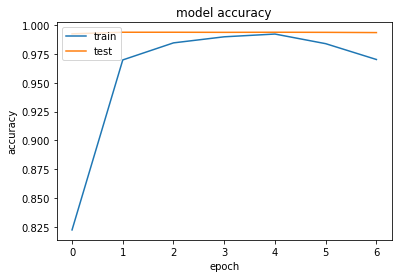

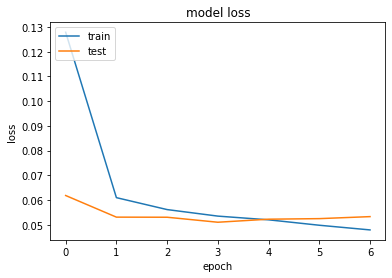

In [ ]:
# Plot Training Loss and Accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test_padded_sequences)
train_pred = model.predict(X_train_padded_sequences)

In [ ]:
loss = log_loss(y_test,y_pred)
print("Log_loss : {}".format(loss))

Log_loss : 0.28500784820953934


In [ ]:
AUC = np.zeros((2,6))

for i,x in enumerate(CLASSES):
    auc = np.array([roc_auc_score(y_train[:,i], train_pred[:,i]),
                    roc_auc_score(y_test[:,i], y_pred[:,i])])
    print(x,"Train AUC:",auc[0],", Test AUC:",auc[1])
    AUC[:,i] = auc
    
avg_auc = AUC.mean(axis=1)
print("Average Train AUC:",avg_auc[0],", Average Test AUC:",avg_auc[1])

toxic Train AUC: 0.991320230500103 , Test AUC: 0.97964878752359
severe_toxic Train AUC: 0.9905182384676823 , Test AUC: 0.9884441579353741
obscene Train AUC: 0.9942702555061664 , Test AUC: 0.9876559464303226
threat Train AUC: 0.9612456580954769 , Test AUC: 0.9502380072777232
insult Train AUC: 0.9893482191662588 , Test AUC: 0.9838479540286718
identity_hate Train AUC: 0.9686987167355743 , Test AUC: 0.9654021519201363
Average Train AUC: 0.982566886411877 , Average Test AUC: 0.9758728341859696


In [ ]:
test_sequences = tokenizer.texts_to_sequences(test['clean_comment_text'])
test_padded_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                                      padding=PADDING_TYPE, truncating=TRUNC_TYPE)

In [ ]:
!unzip sample_submission.csv.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [ ]:
y_pred = model.predict(test_padded_sequences, batch_size=64, verbose=1)
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission[CLASSES] = y_pred
sample_submission.to_csv('submission.csv', index=False)

## Training with BERT Model

In [ ]:
def convert_to_transformer_inputs(comment, tokenizer, max_sequence_length):
    inputs = tokenizer.encode_plus(comment, None, add_special_tokens=True, 
                                   max_length=max_sequence_length, truncation='longest_first')
        
    input_ids =  inputs["input_ids"]
    input_masks = [1] * len(input_ids)
    input_segments = inputs["token_type_ids"]
    padding_length = max_sequence_length - len(input_ids)
    padding_id = tokenizer.pad_token_id
    input_ids = input_ids + ([padding_id] * padding_length)
    input_masks = input_masks + ([0] * padding_length)
    input_segments = input_segments + ([0] * padding_length)
        
    return [input_ids, input_masks, input_segments]

In [ ]:
def compute_input_arrays(df, columns, tokenizer, max_sequence_length):

    input_ids, input_masks, input_segments = [], [], []

    
    for _, row in df[columns].iterrows():
        t = row.clean_comment_text

        ids, masks, segments = convert_to_transformer_inputs(t, tokenizer, max_sequence_length)
        
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
        
    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]

def compute_output_arrays(df, columns): return np.asarray(df[columns])

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Train features
X_bert_train = compute_input_arrays(X_train, ['clean_comment_text'], bert_tokenizer, MAX_SEQUENCE_LENGTH)

# Validation features
X_bert_val = compute_input_arrays(X_val, ['clean_comment_text'], bert_tokenizer, MAX_SEQUENCE_LENGTH)

# Test features
X_bert_test = compute_input_arrays(X_test, ['clean_comment_text'], bert_tokenizer, MAX_SEQUENCE_LENGTH)

In [ ]:
def create_bert_model():
    _id = Input((MAX_SEQUENCE_LENGTH, ), dtype=tf.int32)
    _mask = Input((MAX_SEQUENCE_LENGTH, ), dtype=tf.int32)
    _atn = Input((MAX_SEQUENCE_LENGTH, ), dtype=tf.int32)

    config = BertConfig()
    config.output_hidden_states = False
    pretrained_model = TFBertModel.from_pretrained('bert-base-uncased', config=config)

    embedding = pretrained_model(_id, attention_mask=_mask, token_type_ids=_atn)[0]

    x = GlobalAveragePooling1D()(embedding)

    x = Dense(256, activation='relu')(x)

    x = Dropout(0.5)(x)

    output = Dense(N_CLASS, activation='sigmoid', kernel_initializer=glorot_uniform(seed=42))(x)

    model = Model(inputs=[_id, _mask, _atn], outputs=output)
    
    return model

In [ ]:
K.clear_session()
bert_model = create_bert_model()
bert_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]         

In [ ]:
auc_score = AUC(multi_label=True)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=ES_PATIENCE, verbose=1, mode='min')

filepath = "best_bert_weights.h5"
custom_checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_auc', verbose=1,
                                    save_best_only=True , mode="max" , save_weights_only = True)

callback_list = [custom_checkpoint, early_stopping]

bert_model.compile(loss='binary_crossentropy', optimizer = Adam(lr=3e-5), metrics = [auc_score])

bert_history = bert_model.fit(X_bert_train, y_train, validation_data=(X_bert_val, y_val), 
                              epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=callback_list)

In [ ]:
y_pred = bert_model.predict(X_bert_test)
train_pred = bert_model.predict(X_bert_train)

In [ ]:
loss = log_loss(y_test,y_pred)
print("Log_loss : {}".format(loss))

In [ ]:
AUC = np.zeros((2,6))

for i,x in enumerate(CLASSES):
    auc = np.array([roc_auc_score(y_train[:,i], train_pred[:,i]),
                    roc_auc_score(y_test[:,i], y_pred[:,i])])
    print(x,"Train AUC:",auc[0],", Test AUC:",auc[1])
    AUC[:,i] = auc
    
avg_auc = AUC.mean(axis=1)
print("Average Train AUC:",avg_auc[0],", Average Test AUC:",avg_auc[1])

In [ ]:
test_inputs = compute_bert_input(test, features, bert_tokenizer, MAX_SEQUENCE_LENGTH)

(127656, 1) (31915, 1) (153164, 1)


In [ ]:
b = bert_model.predict(test_inputs)
sub = pd.DataFrame(b, columns=CLASSES)
sub["id"] = test["id"].values
result = sub[CLASSES]
result.to_csv("bert-submission.csv", index=False)

## Training with Albert Model

In [ ]:
def create_albert_model():
    _id = Input((MAX_SEQUENCE_LENGTH, ), dtype=tf.int32)
    _mask = Input((MAX_SEQUENCE_LENGTH, ), dtype=tf.int32)
    _atn = Input((MAX_SEQUENCE_LENGTH, ), dtype=tf.int32)

    albert_config = AlbertConfig.from_pretrained('albert-base-v2', output_hidden_states=True)
    pretrained_model = TFAlbertModel.from_pretrained('albert-base-v2', config=albert_config)

    embedding = pretrained_model(_id, attention_mask=_mask, token_type_ids=_atn)[0]

    x = GlobalAveragePooling1D()(embedding)

    x = Dense(256, activation='relu')(x)

    x = Dropout(0.5)(x)

    output = Dense(N_CLASS, activation='sigmoid', kernel_initializer=glorot_uniform(seed=42))(x)

    model = Model(inputs=[_id, _mask, _atn], outputs=output)

    return model

In [ ]:
K.clear_session()
albert_model = create_albert_model()
albert_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
tf_albert_model (TFAlbertModel) TFBaseModelOutputWit 11683584    input_1[0][0]                    
                                                                 input_2[0][0]         

In [ ]:
albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# Train features
X_albert_train = compute_input_arrays(X_train, ['clean_comment_text'], albert_tokenizer, MAX_SEQUENCE_LENGTH)

# Validation features
X_albert_val = compute_input_arrays(X_val, ['clean_comment_text'], albert_tokenizer, MAX_SEQUENCE_LENGTH)

# Test features
X_albert_test = compute_input_arrays(X_test, ['clean_comment_text'], albert_tokenizer, MAX_SEQUENCE_LENGTH)

In [ ]:
auc_score = AUC(multi_label=True)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=ES_PATIENCE, verbose=1, mode='min')

filepath = "best_albert_weights.h5"
custom_checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_auc', verbose=1,
                                    save_best_only=True, mode="max", save_weights_only = True)

callback_list = [custom_checkpoint, early_stopping]

albert_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=3e-5), metrics=[auc_score])

albert_history = albert_model.fit(X_albert_train, y_train, validation_data=(X_albert_val, y_val), 
                              epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=callback_list)

In [ ]:
y_pred = albert_model.predict(X_albert_test)
train_pred = albert_model.predict(X_albert_train)

In [ ]:
loss = log_loss(y_test,y_pred)
print("Log_loss : {}".format(loss))

In [ ]:
AUC = np.zeros((2,6))

for i,x in enumerate(CLASSES):
    auc = np.array([roc_auc_score(y_train[:,i], train_pred[:,i]),
                    roc_auc_score(y_test[:,i], y_pred[:,i])])
    print(x,"Train AUC:",auc[0],", Test AUC:",auc[1])
    AUC[:,i] = auc
    
avg_auc = AUC.mean(axis=1)
print("Average Train AUC:",avg_auc[0],", Average Test AUC:",avg_auc[1])

In [ ]:
test_inputs = compute_input_arrays(test, features, albert_tokenizer, MAX_SEQUENCE_LENGTH)

In [ ]:
a = albert_model.predict(test_inputs)
sub = pd.DataFrame(a, columns=CLASSES)
sub["id"] = test["id"].values
result = sub[CLASSES]
result.to_csv("submission.csv", index=False)

## Training with the RoBERTa Model

In [ ]:
def convert_to_roberta_inputs(comment, tokenizer, max_sequence_length):
    inputs = tokenizer.encode_plus(comment, None, add_special_tokens=True, 
                                   max_length=max_sequence_length, truncation='longest_first')
    input_ids =  inputs["input_ids"]
    input_masks = [1] * len(input_ids)
    padding_length = max_sequence_length - len(input_ids)
    padding_id = tokenizer.pad_token_id
    input_ids = input_ids + ([padding_id] * padding_length)
    input_masks = input_masks + ([0] * padding_length)
        
    return [input_ids, input_masks]

In [ ]:
def compute_roberta_input(df, columns, tokenizer, max_sequence_length):
    
    input_ids, input_masks = [], []
    
    for _, row in df[columns].iterrows():
        
        t = row.clean_comment_text

        ids, masks = convert_to_roberta_inputs(t, tokenizer, max_sequence_length)
        
        input_ids.append(ids)
        input_masks.append(masks)
        
    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32)]

In [ ]:
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Train features
X_roberta_train = compute_roberta_input(X_train, ['clean_comment_text'], roberta_tokenizer, MAX_SEQUENCE_LENGTH)

# Validation features
X_roberta_val = compute_roberta_input(X_val, ['clean_comment_text'], roberta_tokenizer, MAX_SEQUENCE_LENGTH)

# Test features
X_roberta_test = compute_roberta_input(X_test, ['clean_comment_text'], roberta_tokenizer, MAX_SEQUENCE_LENGTH)

In [ ]:
def create_roberta_model():    
    
    _id = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    _mask = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    _atn = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    config = RobertaConfig()
    config.output_hidden_states = False

    bert_model = TFRobertaModel.from_pretrained('roberta-base')

    embedding = bert_model(_id, attention_mask=_mask)[0]
    
    x = GlobalAveragePooling1D()(embedding)

    x = Dense(256, activation='relu')(x)
    
    x = Dropout(0.5)(x)

    output = Dense(N_CLASS, activation='sigmoid', kernel_initializer=glorot_uniform(seed=42))(x)

    model = Model(inputs=[_id, _mask], outputs=output)

    return model

In [ ]:
K.clear_session()
roberta_model = create_roberta_model()
roberta_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           tf_roberta_model[0][0]

In [ ]:
auc_score = AUC(multi_label=True)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=ES_PATIENCE, verbose=1, mode='min')

filepath = "best_roberta_weights.h5"
custom_checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_auc', verbose=1,
                                    save_best_only=True, mode="max", save_weights_only = True)

callback_list = [custom_checkpoint, early_stopping]

roberta_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=3e-5), metrics=[auc_score])

roberta_history = roberta_model.fit(X_roberta_train, y_train, validation_data=(X_roberta_val, y_val), 
                              epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=callback_list)

In [ ]:
y_pred = roberta_model.predict(X_roberta_test)
train_pred = roberta_model.predict(X_roberta_train)

In [ ]:
loss = log_loss(y_test,y_pred)
print("Log_loss : {}".format(loss))

In [ ]:
AUC = np.zeros((2,6))

for i,x in enumerate(CLASSES):
    auc = np.array([roc_auc_score(y_train[:,i], train_pred[:,i]),
                    roc_auc_score(y_test[:,i], y_pred[:,i])])
    print(x,"Train AUC:",auc[0],", Test AUC:",auc[1])
    AUC[:,i] = auc
    
avg_auc = AUC.mean(axis=1)
print("Average Train AUC:",avg_auc[0],", Average Test AUC:",avg_auc[1])

In [ ]:
test_inputs = compute_roberta_input(test, ['clean_comment_text'], roberta_tokenizer, MAX_SEQUENCE_LENGTH)

In [ ]:
r = roberta_model.predict(test_inputs)
sub = pd.DataFrame(r, columns=CLASSES)
sub["id"] = test["id"].values
result = sub[CLASSES]
result.to_csv("submission.csv", index=False)